<a href="https://colab.research.google.com/github/KillerStrike17/10DaysofMLChallenge/blob/master/Day4/Day4_Clustering_using_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day4


## Problem Statement

Introduction to Unsupervised Learning
https://algorithmia.com/blog/introduction-to-unsupervised-learning

“Unsupervised Learning and Data Clustering” by Sanatan Mishra https://link.medium.com/RUlFBArf94
“Unsupervised Learning: Dimensionality Reduction” by Victor Roman https://link.medium.com/eZStdrvf94

Dataset link: https://www.kaggle.com/c/expedia-personalized-sort/data

Task: Prepare a model on the above Dataset

## Importing Libraries

In [1]:
!nvidia-smi

Tue Mar 31 21:11:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#Calling the Gods
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gc
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install -q kaggle

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth



auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

In [3]:
# Code to Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


## Data Loading

In [0]:
!kaggle competitions download -c expedia-personalized-sort

 96% 26.0M/27.1M [00:00<00:00, 21.4MB/s]
100% 27.1M/27.1M [00:00<00:00, 61.3MB/s]
 99% 412M/414M [00:03<00:00, 115MB/s] 
100% 414M/414M [00:04<00:00, 108MB/s]
 63% 17.0M/27.2M [00:00<00:00, 23.2MB/s]
100% 27.2M/27.2M [00:00<00:00, 38.3MB/s]
 19% 5.00M/26.0M [00:00<00:01, 16.3MB/s]
100% 26.0M/26.0M [00:00<00:00, 58.6MB/s]


In [0]:
!cp /content/gdrive/My\ Drive/Kaggle_Competitions_Dataset/Expedia_dataset/data.zip /content/

In [5]:
!unzip data.zip

Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


## Data Extraction and Processing

In [0]:
train_csv = pd.read_csv('train.csv')

In [7]:
train_csv

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917525,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,32019,4,3.5,0,2.48,0.0551,4.53,2,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,22.0,1.0,0.0,127.0,-1.0,0.0,27.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
9917526,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,33959,4,3.0,1,2.20,0.3344,4.39,6,67.10,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,16.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,154.34,1
9917527,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,35240,4,0.0,0,1.79,NaN,4.64,8,73.91,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,55.0,0.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
9917528,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,94437,4,0.0,0,2.94,0.0928,4.64,7,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,43.0,1.0,0.0,43.0,-1.0,0.0,12.0,-1.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [8]:
train_csv.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        9412233
visitor_hist_adr_usd           9409918
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                14630
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           2178380
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      9281966
orig_destination_distance

In [0]:
train_csv = train_csv.dropna(subset=['prop_review_score'])
train_csv = train_csv.dropna(axis =1)

In [10]:
train_csv

,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool,click_bool,booking_bool
0,1,2013-04-04 08:32:15,12,187,219,893,3,3.5,1,2.83,4.95,27,104.77,0,23246,1,0,4,0,1,1,1,0,0
1,1,2013-04-04 08:32:15,12,187,219,10404,4,4.0,1,2.20,5.03,26,170.74,0,23246,1,0,4,0,1,1,1,0,0
2,1,2013-04-04 08:32:15,12,187,219,21315,3,4.5,1,2.20,4.92,21,179.80,0,23246,1,0,4,0,1,1,1,0,0
3,1,2013-04-04 08:32:15,12,187,219,27348,2,4.0,1,2.83,4.39,34,602.77,0,23246,1,0,4,0,1,1,1,0,0
4,1,2013-04-04 08:32:15,12,187,219,29604,4,3.5,1,2.64,4.93,4,143.58,0,23246,1,0,4,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917525,665574,2013-05-21 11:06:37,24,216,117,32019,4,3.5,0,2.48,4.53,2,66.07,0,19246,2,7,1,0,1,0,0,0,0
9917526,665574,2013-05-21 11:06:37,24,216,117,33959,4,3.0,1,2.20,4.39,6,67.10,0,19246,2,7,1,0,1,0,0,1,1
9917527,665574,2013-05-21 11:06:37,24,216,117,35240,4,0.0,0,1.79,4.64,8,73.91,0,19246,2,7,1,0,1,0,0,0,0
9917528,665574,2013-05-21 11:06:37,24,216,117,94437,4,0.0,0,2.94,4.64,7,66.07,0,19246,2,7,1,0,1,0,0,0,0


In [0]:
data = train_csv.copy()

In [12]:
train_csv.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_log_historical_price',
       'position', 'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool', 'click_bool', 'booking_bool'],
      dtype='object')

## Model Building and Visualization

In [13]:
data['prop_id'].value_counts()

104517    4733
124342    4707
68420     4580
134154    4550
40279     4535
          ... 
127765       1
75246        1
37691        1
4906         1
117288       1
Name: prop_id, Length: 134859, dtype: int64

In [14]:
data['visitor_location_country_id'].value_counts()

219    5773340
100     989389
55      578879
216     433010
220     349764
        ...   
171         31
198         30
146         30
24          29
8           25
Name: visitor_location_country_id, Length: 218, dtype: int64

In [15]:
# Num of rooms specified in search by customer
data['srch_room_count'].value_counts()

1    9032269
2     733340
3      92287
4      24988
5       8041
8       4946
6       4339
7       2690
Name: srch_room_count, dtype: int64

In [0]:
# Subset df 
data = data.loc[data['prop_id'] == 104517]

data = data.loc[data['visitor_location_country_id'] == 219]

data = data.loc[data['srch_room_count'] == 1]

In [0]:
data = data[[ 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool','srch_length_of_stay','promotion_flag','booking_bool']]

In [18]:
data.describe()


,price_usd,srch_booking_window,srch_saturday_night_bool,srch_length_of_stay,promotion_flag,booking_bool
count,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000
mean,112.939023,37.082650,0.524434,2.409970,0.913414,0.041981
std,113.374049,46.160272,0.499485,1.396417,0.281273,0.200579
min,0.120000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,67.000000,6.000000,0.000000,2.000000,1.000000,0.000000
50%,100.000000,20.000000,1.000000,2.000000,1.000000,0.000000
75%,141.000000,48.000000,1.000000,3.000000,1.000000,0.000000
max,5584.000000,292.000000,1.000000,28.000000,1.000000,1.000000


In [19]:
data = data.loc[data['price_usd'] < 5584]
data.describe()

,price_usd,srch_booking_window,srch_saturday_night_bool,srch_length_of_stay,promotion_flag,booking_bool
count,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000
mean,111.144055,37.090551,0.524606,2.409121,0.913386,0.041995
std,55.055161,46.165784,0.499476,1.395857,0.281315,0.200610
min,0.120000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,67.000000,6.000000,0.000000,2.000000,1.000000,0.000000
50%,100.000000,20.000000,1.000000,2.000000,1.000000,0.000000
75%,141.000000,48.000000,1.000000,3.000000,1.000000,0.000000
max,536.000000,292.000000,1.000000,28.000000,1.000000,1.000000


In [0]:
n_cluster = range(1, 20)

kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

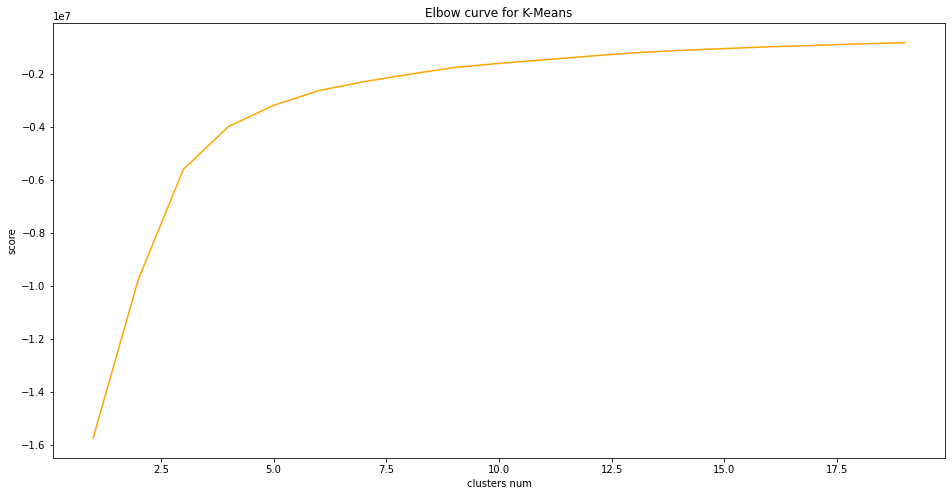

In [23]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(n_cluster, scores, color = 'orange')

plt.xlabel('clusters num')
plt.ylabel('score')
plt.title('Elbow curve for K-Means')
plt.show()

In [24]:
data['promotion_flag'].unique()

array([1, 0])

In [25]:
data

,price_usd,srch_booking_window,srch_saturday_night_bool,srch_length_of_stay,promotion_flag,booking_bool
2041,206.0,99,1,3,1,0
3152,186.0,6,0,3,1,0
5166,61.0,1,0,1,1,0
10135,72.0,116,0,3,1,0
10560,246.0,245,0,2,1,0
...,...,...,...,...,...,...
9908584,107.0,30,1,3,1,0
9911528,81.0,73,0,1,1,0
9915868,59.0,33,0,6,1,0
9916580,71.0,59,0,2,1,0


(3048, 6)


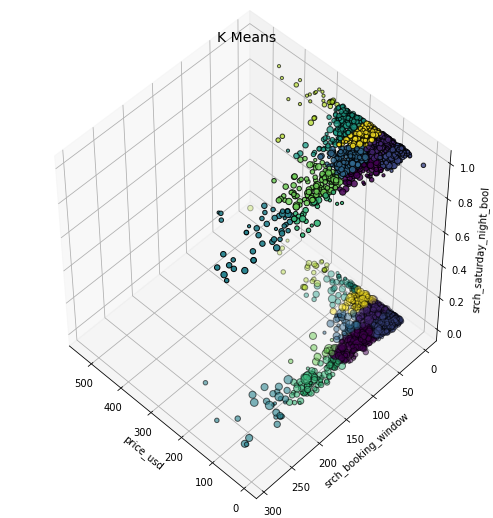

In [27]:
X = data
print(data.shape)
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],c=labels.astype(np.float), edgecolor="k", s= X.iloc[:,3]*10)
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14)
plt.show()

In [28]:
km.cluster_centers_

array([[7.36294798e+01, 6.12687861e+01, 2.05202312e-01, 2.97398844e+00,
        9.21965318e-01, 5.49132948e-02],
       [1.06588255e+02, 1.34004107e+01, 6.44763860e-01, 2.40246407e+00,
        9.28131417e-01, 4.10677618e-02],
       [6.20626382e+01, 1.31820276e+01, 2.41935484e-01, 2.12327189e+00,
        9.19354839e-01, 5.41474654e-02],
       [1.29453784e+02, 5.53513514e+01, 8.49420849e-01, 2.61776062e+00,
        9.30501931e-01, 4.63320463e-02],
       [1.13083973e+02, 2.15602740e+02, 6.16438356e-01, 3.04109589e+00,
        9.58904110e-01, 1.36986301e-02],
       [2.06814189e+02, 1.86301887e+01, 8.11320755e-01, 2.08301887e+00,
        8.98113208e-01, 1.88679245e-02],
       [7.31754386e+01, 1.43245614e+02, 2.54385965e-01, 3.18421053e+00,
        9.12280702e-01, 5.26315789e-02],
       [1.30863284e+02, 1.13373134e+02, 8.95522388e-01, 2.73880597e+00,
        9.10447761e-01, 2.98507463e-02],
       [3.06639344e+02, 1.78688525e+01, 5.40983607e-01, 1.90163934e+00,
        8.36065574e-01, 